# Part 01 - EDA with Pyspark

Gradient Boosted Trees applied to Fraud detection

#### Pyspark libraries

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, countDistinct
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, array, lit
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier

#### Python libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
spark = SparkSession.builder.appName('FraudTreeMethods').getOrCreate()

## Read Data

In [4]:
# Load and parse the data file, converting it to a DataFrame.
#data = sqlContext.sql("SELECT * FROM fraud_train_sample_csv")
RDD = spark.read.csv('train_sample.csv', inferSchema=True, header=True)

In [5]:
RDD.show(5)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 87540| 12|     1| 13|    497|2017-11-07 09:30:38|           null|            0|
|105560| 25|     1| 17|    259|2017-11-07 13:40:27|           null|            0|
|101424| 12|     1| 19|    212|2017-11-07 18:05:24|           null|            0|
| 94584| 13|     1| 13|    477|2017-11-07 04:58:08|           null|            0|
| 68413| 12|     1|  1|    178|2017-11-09 09:00:09|           null|            0|
+------+---+------+---+-------+-------------------+---------------+-------------+
only showing top 5 rows



## Convert the click time to day and hour and add it to data.

In [6]:
import datetime
from pyspark.sql.functions import year, month, dayofmonth

In [7]:
from pyspark.sql.functions import hour, minute, dayofmonth
RDD = RDD.withColumn('hour',hour(RDD.click_time)).\
             withColumn('day',dayofmonth(RDD.click_time))

RDD.show(5)

+------+---+------+---+-------+-------------------+---------------+-------------+----+---+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|hour|day|
+------+---+------+---+-------+-------------------+---------------+-------------+----+---+
| 87540| 12|     1| 13|    497|2017-11-07 09:30:38|           null|            0|   9|  7|
|105560| 25|     1| 17|    259|2017-11-07 13:40:27|           null|            0|  13|  7|
|101424| 12|     1| 19|    212|2017-11-07 18:05:24|           null|            0|  18|  7|
| 94584| 13|     1| 13|    477|2017-11-07 04:58:08|           null|            0|   4|  7|
| 68413| 12|     1|  1|    178|2017-11-09 09:00:09|           null|            0|   9|  9|
+------+---+------+---+-------+-------------------+---------------+-------------+----+---+
only showing top 5 rows



## Feathering

Feathering, grouping-merging as follow.

In python EDA we did following:
```python
gp = df[['ip','day','hour','channel']]\
    .groupby(by=['ip','day','hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': '*ip_day_hour_count_channel'})
df = df.merge(gp, on=['ip','day','hour'], how='left')

```
We translate it to Pyspark as follow.

In [8]:
gp = RDD.select("ip","day","hour", "channel")\
               .groupBy("ip","day","hour")\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_day_hour_count_channel")\
               .sort(col("ip"))
RDD = RDD.join(gp, ["ip","day","hour"])\
         .sort(col("ip"))

In [9]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'day', 'hour', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel']


In python EDA we did following:
```python
gp = df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].\
            count().reset_index().\
            rename(index=str, columns={'channel': '*ip_app_count_channel'})
df = df.merge(gp, on=['ip','app'], how='left')

```
We translate it to Pyspark as follow.

In [10]:
gp = RDD.select("ip","app", "channel")\
               .groupBy("ip","app")\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_app_count_channel")\
               .sort(col("ip"))
RDD = RDD.join(gp, ["ip","app"])\
         .sort(col("ip"))

In [11]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'day', 'hour', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel']


In python EDA we did following:
```python
gp = df[['ip','app', 'os', 'channel']].\
            groupby(by=['ip', 'app', 'os'])[['channel']].\
            count().reset_index().\
            rename(index=str, columns={'channel': '*ip_app_os_count_channel'})
df = df.merge(gp, on=['ip','app', 'os'], how='left')

```
We translate it to Pyspark as follow.

In [12]:
gp = RDD.select('ip','app', 'os', 'channel')\
               .groupBy('ip', 'app', 'os')\
               .agg({"channel":"count"})\
               .withColumnRenamed("count(channel)", "*ip_app_os_count_channel")\
               .sort(col("ip"))
RDD = RDD.join(gp, ['ip','app', 'os'])\
         .sort(col("ip"))

In [13]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'os', 'day', 'hour', 'device', 'channel', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel', '*ip_app_os_count_channel']


In python EDA we did following:
```python
gp = df[['ip','day','hour','channel']].\
            groupby(by=['ip','day','channel'])[['hour']].\
            var().reset_index().\
            rename(index=str, columns={'hour': '*ip_day_chan_var_hour'})
df = df.merge(gp, on=['ip','day','channel'], how='left')

```
We translate it to Pyspark as follow.

In [14]:
gp = RDD.select('ip','day','hour','channel')\
               .groupBy('ip','day','channel')\
               .agg({"hour":"variance"})\
               .withColumnRenamed("variance(hour)", "*ip_day_chan_var_hour")\
               .sort(col("ip"))

Check out the number of nan and null in the gp.

In [15]:
from pyspark.sql.functions import isnan, when, count, col
gp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in gp.columns]).show()

+---+---+-------+---------------------+
| ip|day|channel|*ip_day_chan_var_hour|
+---+---+-------+---------------------+
|  0|  0|      0|                89123|
+---+---+-------+---------------------+



We remeber from python EDA the following 

```python
ip                                0
app                               0
device                            0
os                                0
channel                           0
click_time                        0
is_attributed                     0
hour                              0
day                               0
*ip_day_hour_count_channel        0
*ip_app_count_channel             0
*ip_app_os_count_channel          0
*ip_tchan_count               89123
*ip_app_os_var                89715
*ip_app_channel_var_day       84834
*ip_app_channel_mean_hour         0
dtype: int64

```
Therefore we skip the following grouping (columns)as follow.

```python
*ip_tchan_count               10877 non-null float64
*ip_app_os_var                10285 non-null float64
*ip_app_channel_var_day       15166 non-null float64

```
Note that the last gp was not joined into the data.

**Let's Keep going:**

In python EDA we did following:
```python
gp = df[['ip','app', 'channel','hour']].\
            groupby(by=['ip', 'app', 'channel'])[['hour']].\
            mean().reset_index().\
            rename(index=str, columns={'hour': '*ip_app_channel_mean_hour'})

df = df.merge(gp, on=['ip','app', 'channel'], how='left')

```
We translate it to Pyspark as follow.

In [16]:
gp = RDD.select('ip','app', 'channel','hour')\
               .groupBy('ip', 'app', 'channel')\
               .agg({"hour":"mean"})\
               .withColumnRenamed("avg(hour)", "*ip_app_channel_mean_hour")\
               .sort(col("ip"))
RDD = RDD.join(gp, ['ip', 'app', 'channel'])\
         .sort(col("ip"))

In [17]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'channel', 'os', 'day', 'hour', 'device', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel', '*ip_app_os_count_channel', '*ip_app_channel_mean_hour']


### Get summary

In [18]:
# data.summary().show()
cols1 = ['ip', 'app', 'channel',
       'os', 'day', 'hour']
RDD.describe(cols1).show()

+-------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+
|summary|               ip|               app|          channel|               os|               day|             hour|
+-------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+
|  count|           100000|            100000|           100000|           100000|            100000|           100000|
|   mean|      91255.87967|          12.04788|        268.83246|         22.81828|           7.86146|          9.32859|
| stddev|69835.55366125256|14.941499924365017|129.7242482119443|55.94313589875116|0.8892663135111797|6.180585781971326|
|    min|                9|                 1|                3|                0|                 6|                0|
|    max|           364757|               551|              498|              866|                 9|               23|
+-------+-----------------+-------------

In [19]:
cols2 = ['device', 'click_time', 
        'attributed_time','is_attributed']
RDD.describe(cols2).show()

+-------+----------------+-------------------+-------------------+------------------+
|summary|          device|         click_time|    attributed_time|     is_attributed|
+-------+----------------+-------------------+-------------------+------------------+
|  count|          100000|             100000|                227|            100000|
|   mean|        21.77125|               null|               null|           0.00227|
| stddev|259.667767420086|               null|               null|0.0475906477020169|
|    min|               0|2017-11-06 16:00:00|2017-11-06 17:19:04|                 0|
|    max|            3867|2017-11-09 15:59:51|2017-11-09 15:28:15|                 1|
+-------+----------------+-------------------+-------------------+------------------+



In [20]:
cols3 = ['*ip_day_hour_count_channel',
       '*ip_app_count_channel',
       '*ip_app_os_count_channel']
RDD.describe(cols3).show()

+-------+--------------------------+---------------------+------------------------+
|summary|*ip_day_hour_count_channel|*ip_app_count_channel|*ip_app_os_count_channel|
+-------+--------------------------+---------------------+------------------------+
|  count|                    100000|               100000|                  100000|
|   mean|                   1.49328|              3.58026|                 1.29488|
| stddev|        2.0205929005014074|   10.553763885539674|      1.6443882831400423|
|    min|                         1|                    1|                       1|
|    max|                        28|                  132|                      33|
+-------+--------------------------+---------------------+------------------------+



Check out the uniques number for each column in data.

In [21]:
from pyspark.sql.functions import col, countDistinct

In [22]:
cols4 = cols1 + cols2
RDD.agg(*(countDistinct(col(c)).alias(c) for c in cols4)).show()

+-----+---+-------+---+---+----+------+----------+---------------+-------------+
|   ip|app|channel| os|day|hour|device|click_time|attributed_time|is_attributed|
+-----+---+-------+---+---+----+------+----------+---------------+-------------+
|34857|161|    161|130|  4|  24|   100|     80350|            227|            2|
+-----+---+-------+---+---+----+------+----------+---------------+-------------+



In [23]:
RDD.agg(*(countDistinct(col(c)).alias(c) for c in cols3)).show()

+--------------------------+---------------------+------------------------+
|*ip_day_hour_count_channel|*ip_app_count_channel|*ip_app_os_count_channel|
+--------------------------+---------------------+------------------------+
|                        27|                   58|                      23|
+--------------------------+---------------------+------------------------+



## Over sampling the data

* Over sampling
* Duplicate the minority rows
* Combine both oversampled minority rows and previous majority rows

In [24]:
# over sampling
major_df = RDD.filter(col("is_attributed") == 0)
minor_df = RDD.filter(col("is_attributed") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
a = range(ratio)

ratio: 439


In [25]:
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

In [26]:
# combine both oversampled minority rows and previous majority rows combined_df = major_df.unionAll(oversampled_df)
RDD = major_df.unionAll(oversampled_df)

In [27]:
print("RDD Columns name = \n", RDD.columns)

RDD Columns name = 
 ['ip', 'app', 'channel', 'os', 'day', 'hour', 'device', 'click_time', 'attributed_time', 'is_attributed', '*ip_day_hour_count_channel', '*ip_app_count_channel', '*ip_app_os_count_channel', '*ip_app_channel_mean_hour']


### Turn RDD to pandas and use pandas ability for visualization

* First take a sample from big RDD
* Pass the sample into the pandas data frame

In [28]:
sub_RDD = RDD.sample(False, 0.01, 42)
data_pd = sub_RDD.toPandas()

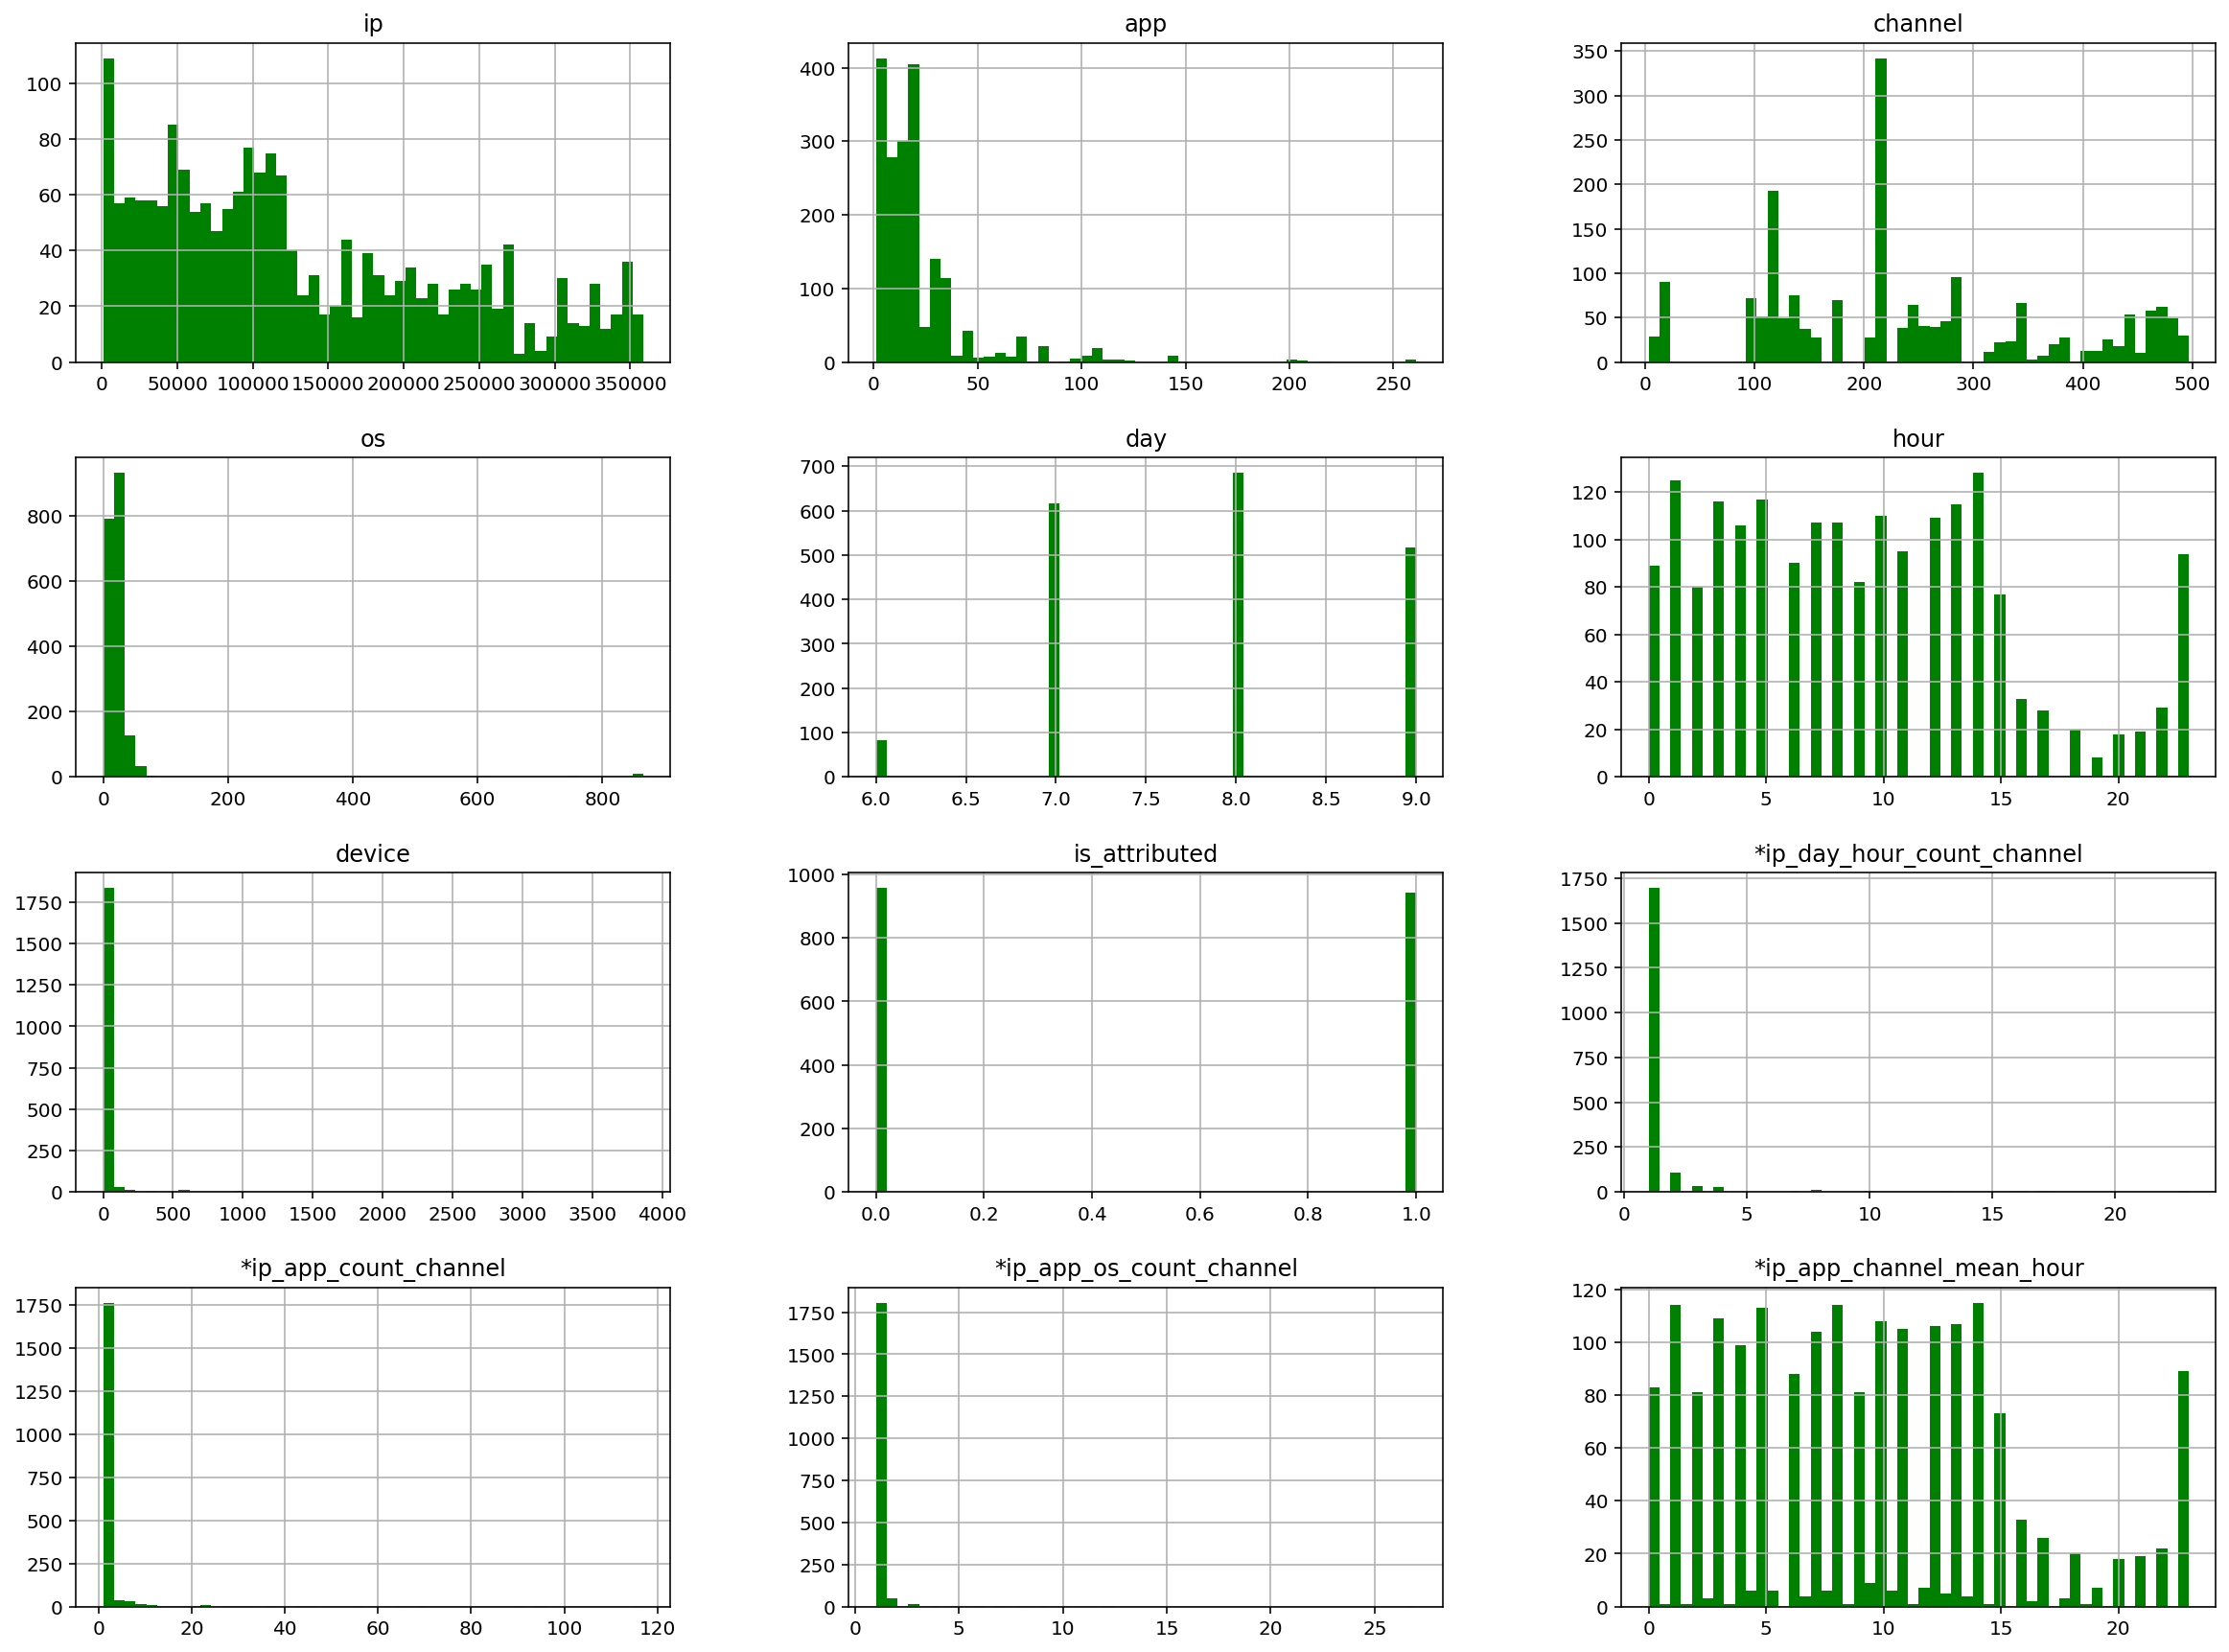

In [29]:
data_pd.hist(bins=50, 
             figsize=(20,15),
             facecolor='green')
plt.show()

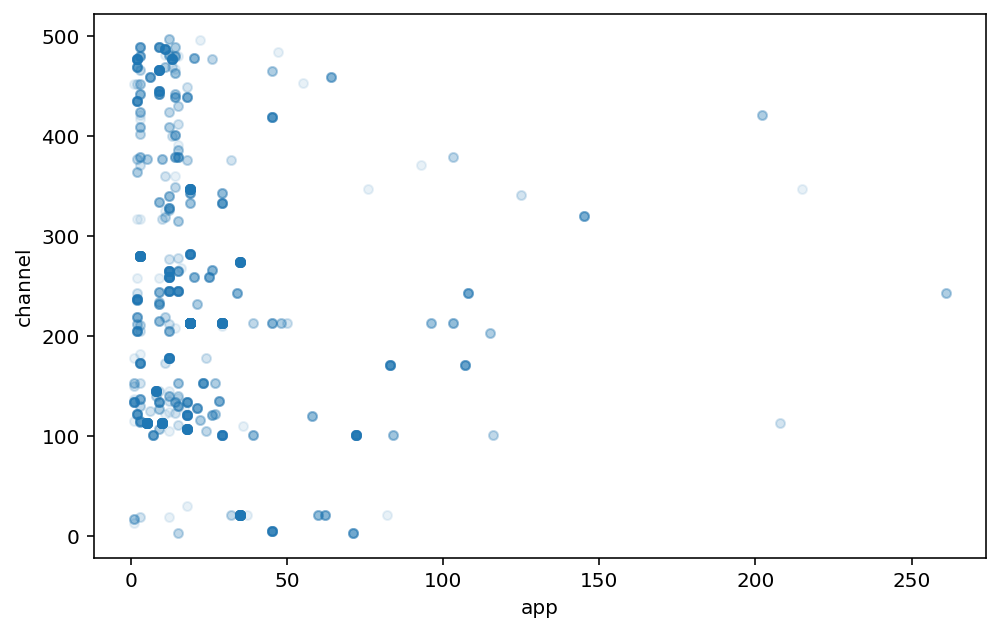

In [30]:
data_pd.plot(kind="scatter", 
             x="app", 
             y="channel", 
             alpha=0.1, 
             figsize=(8,5))

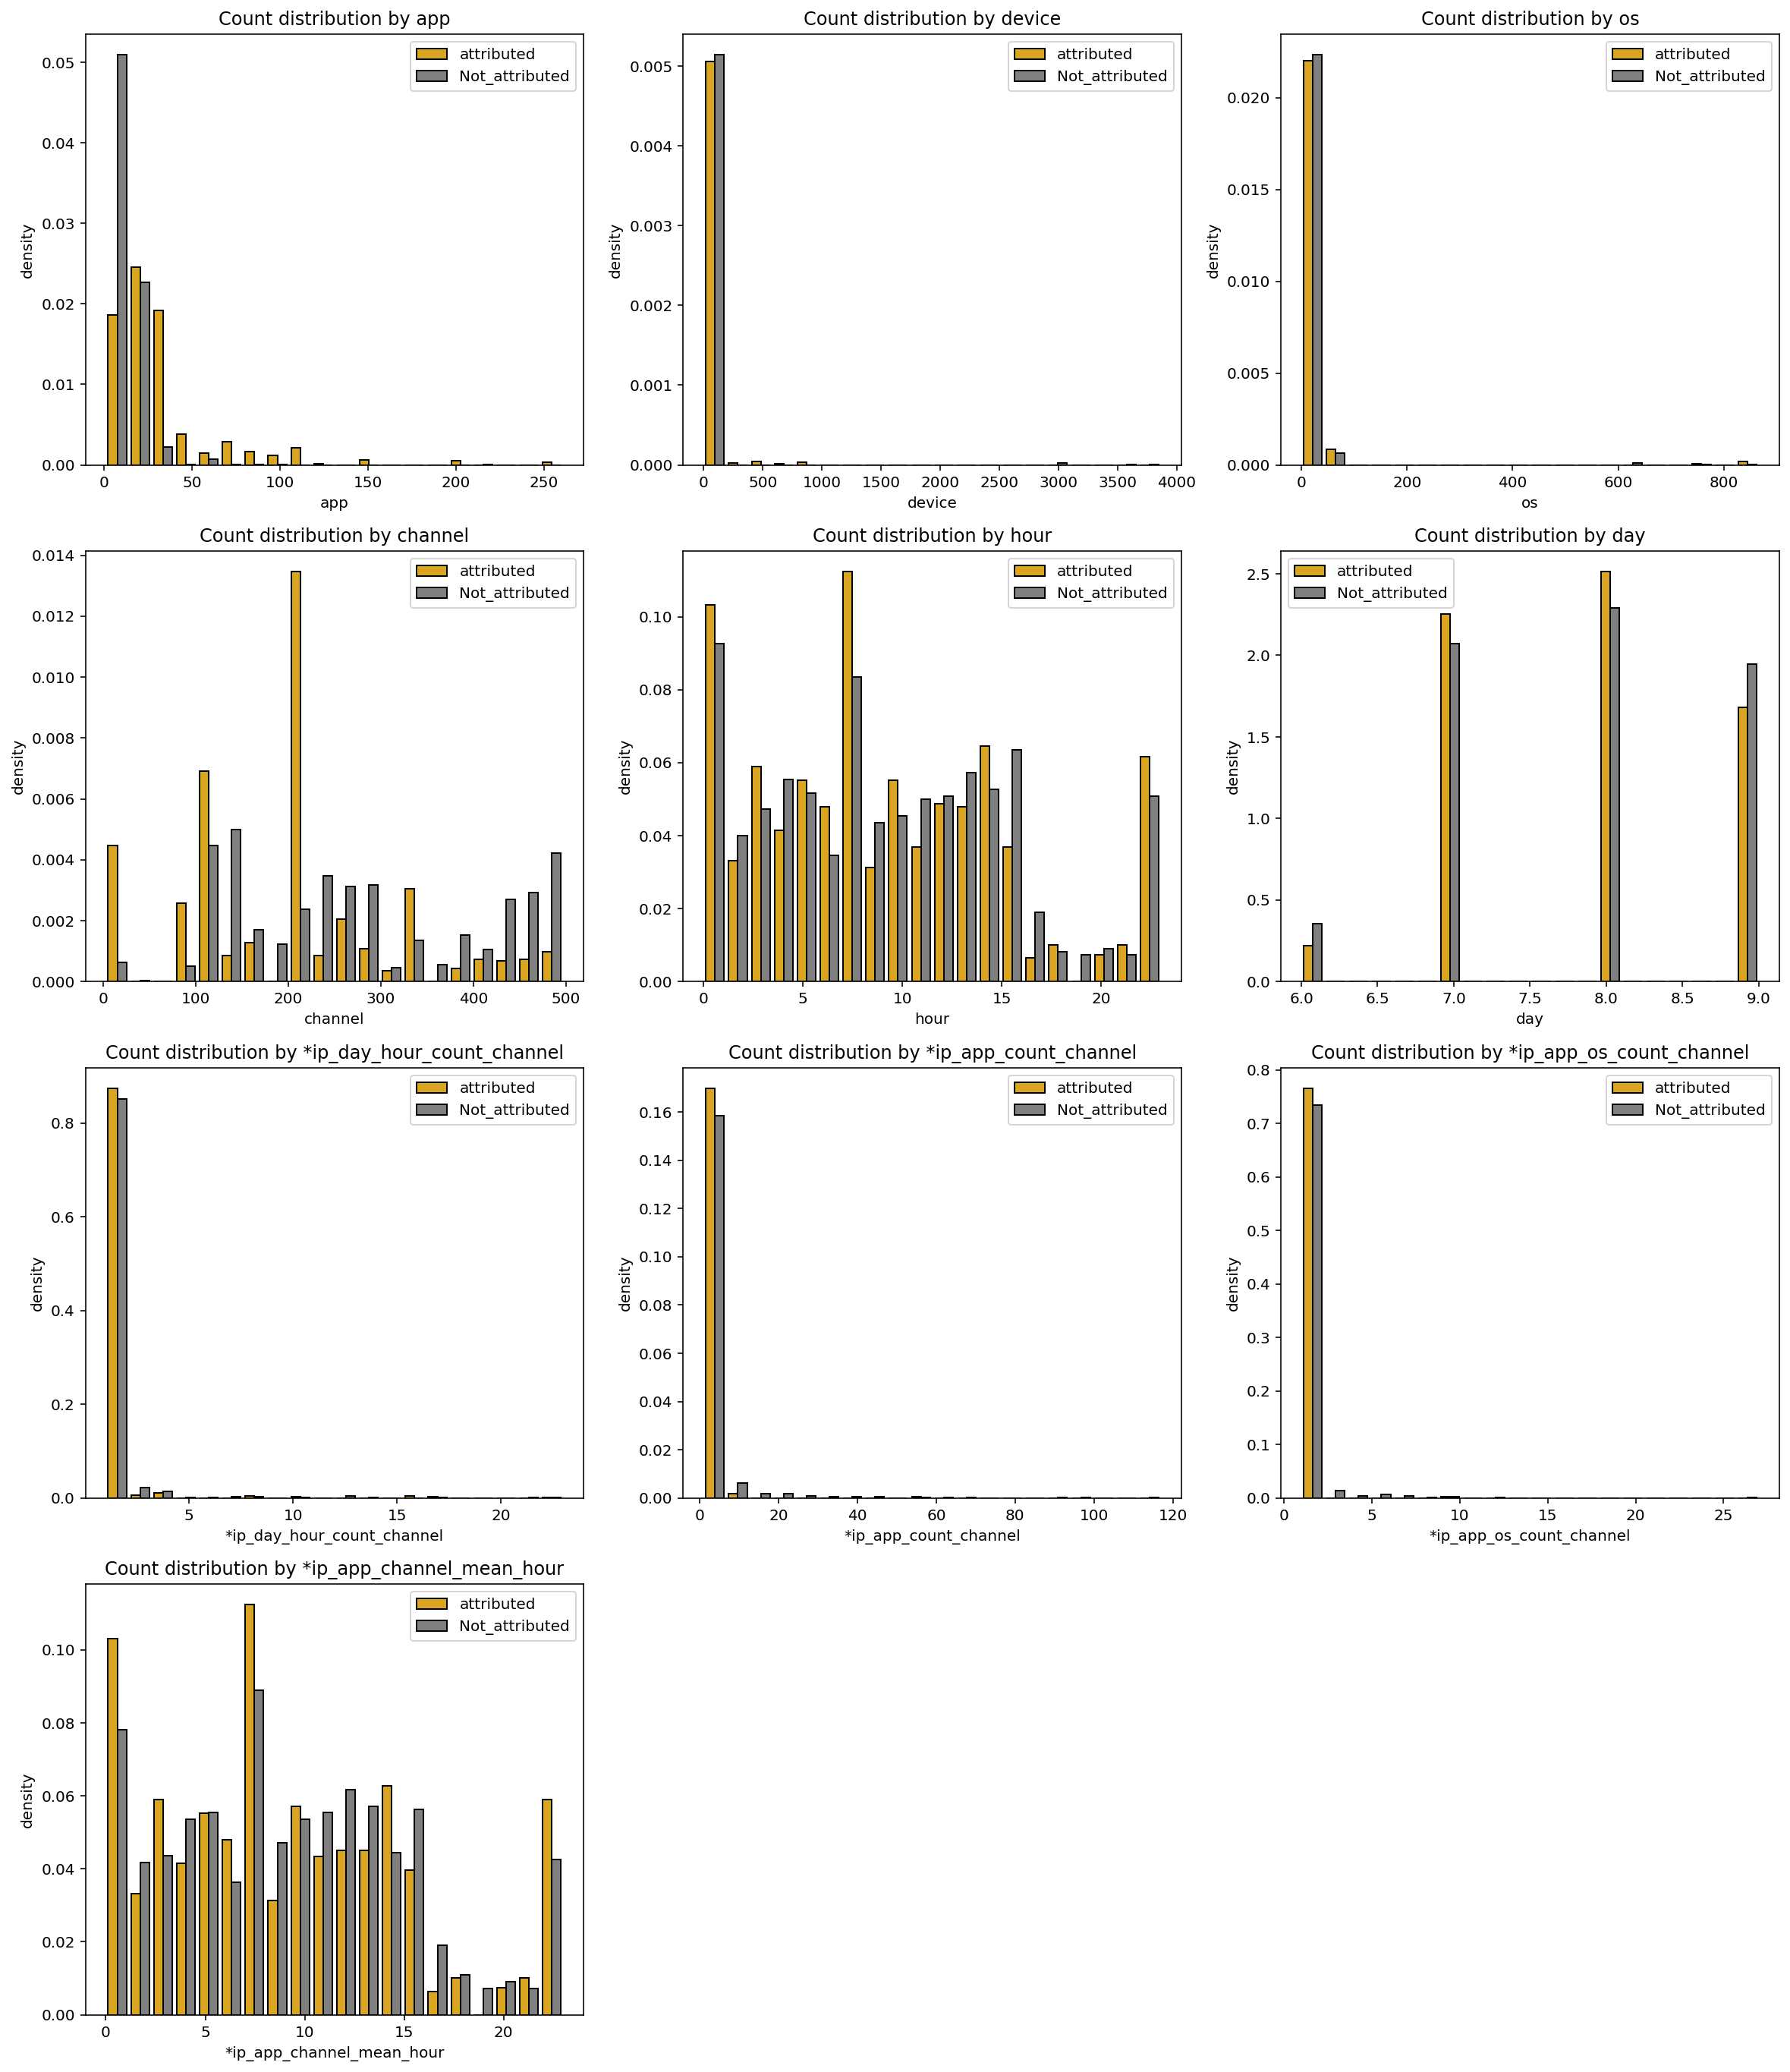

In [31]:
plt.figure(figsize=(20,24))

cols = ['app','device','os', 
        'channel', 'hour', 'day',
        '*ip_day_hour_count_channel', '*ip_app_count_channel',
        '*ip_app_os_count_channel', '*ip_app_channel_mean_hour']

sub_attributed_mask = data_pd["is_attributed"] == 1
sub_Not_attributed_mask = data_pd["is_attributed"] == 0


for count, col in enumerate(cols, 1):
    
    plt.subplot(4, 3, count)
    plt.hist([data_pd[sub_attributed_mask][col], 
          data_pd[sub_Not_attributed_mask][col]],
          color=['goldenrod', 'grey'],
          bins=20, ec='k', density=True)
    
    plt.title('Count distribution by {}'.format(col), fontsize=12)
    plt.legend(['attributed', 'Not_attributed'])
    plt.xlabel(col); plt.ylabel('density')

# path = '../Figures/'
# file_name = 'hist_dens_by_par.png'
# plt.savefig(path+file_name)

### Transfering

Applying the transfering achieved from previous EDA.

In [32]:
trans_colmns = ['app','device','os', 'day', 
                '*ip_day_hour_count_channel', 
                '*ip_app_count_channel', 
                '*ip_app_os_count_channel']

In [39]:
a = RDD.select('app').map(lambda x:(x,1))

AttributeError: 'DataFrame' object has no attribute 'map'

In [38]:
a

In [ ]:



data = data.drop('click_time','attributed_time')

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])
assembler = VectorAssembler(inputCols=['ip', 'app', 'device', 'os', 'channel'],outputCol="features")
trainingData = assembler.transform(trainingData)
testData = assembler.transform(testData)

## Train the model

In [ ]:
# Train a GBT model.
gbt = GBTClassifier(labelCol="is_attributed", featuresCol="features", maxIter=20, maxDepth=4)

# Train model.  This also runs the indexers.
model = gbt.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "is_attributed", "features").show(5)

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="is_attributed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Test accuracy = %g" % (accuracy))

In [ ]:
predictions.groupBy('prediction').count().show()

# Apply to test, predict

In [ ]:
test = spark.read.csv('test.csv', inferSchema=True, header=True)
#test.show(5)

assembler = VectorAssembler(inputCols=['ip', 'app', 'device', 'os', 'channel'],outputCol="features")
test = assembler.transform(test)
#test.show(3)

predictions = model.transform(test)
#predictions.show(2)

data_to_submit = predictions.select(['click_id','prediction'])
data_to_submit.show(3)

data_to_submit = data_to_submit.withColumnRenamed('prediction','is_attributed')
data_to_submit.show(3)

data_to_submit.groupBy('is_attributed').count().show()

In [ ]:
print('it is runing now')